# Smart Meters in London: Data Analysis and ML model (Part 2/2)

There are three main objectives in this project, as stated below:

1. Create a ML algorithm to forecast the electricity consumption for one household considering the prior smart meter data we have. Hence, we could create a Dashboard with Tableau to show the results that end-user has. 

2. Classifying our portfolio clients according to their consumption, but also according to acorn classification. 

3. Analyse the influence of the weather into our energy consumption. This last step could be performed in two ways: considering only one household, or, on the contrary, aggregating all the demand we have in our 6000 clients. 

This second jupyter notebook wants to analyse the data coming from the energy cnsumption of different users, to see how a forecast algorithm can be developed, or clustering models can be done. 

The structure of this notebook is as follows: 

1.  Electricity consumption from end-user MAC000291. TIme Series Analysis


In [49]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os
import sklearn 

# Importing libraries required for T-S analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot

# Seting style for matplotlib
plt.style.use('ggplot')

## 1. Electricity consumption from end-user MAC000291
### 1.1. Basics plots on TS Electricity Consumption

In [24]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/your-project/2.JupyterNotebooks'

In [25]:
# Reading the csv file with the information of MAC000291 end-user's electricity consumption
user_291_df = pd.read_csv('../0.Data/clean_data/MAC000291_cleaned_consumption.csv', index_col=0)

In [26]:
user_291_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


In [27]:
# Checking the types of the user_df 
user_291_df.dtypes

LCLid        object
DateTime     object
kWh/hh      float64
dtype: object

In [28]:
# Changing the type of DateTime column into DateTime 
user_291_df['DateTime'] = pd.to_datetime(user_291_df['DateTime'])

# Setting DateTime as index of the dataframe 
user_291_df.index = user_291_df['DateTime'].sort_index()

# Droping DateTime and LCLid columns 
user_291_df.drop(['DateTime', 'LCLid'], axis = 1, inplace = True )

In [30]:
user_291_df.head()

,kWh/hh
DateTime,
2012-03-02 09:30:00,1.158
2012-03-02 10:00:00,1.499
2012-03-02 10:30:00,1.433
2012-03-02 11:00:00,0.510
2012-03-02 11:30:00,0.455


Text(0, 0.5, 'Electricity consumption [kWh/hh]')

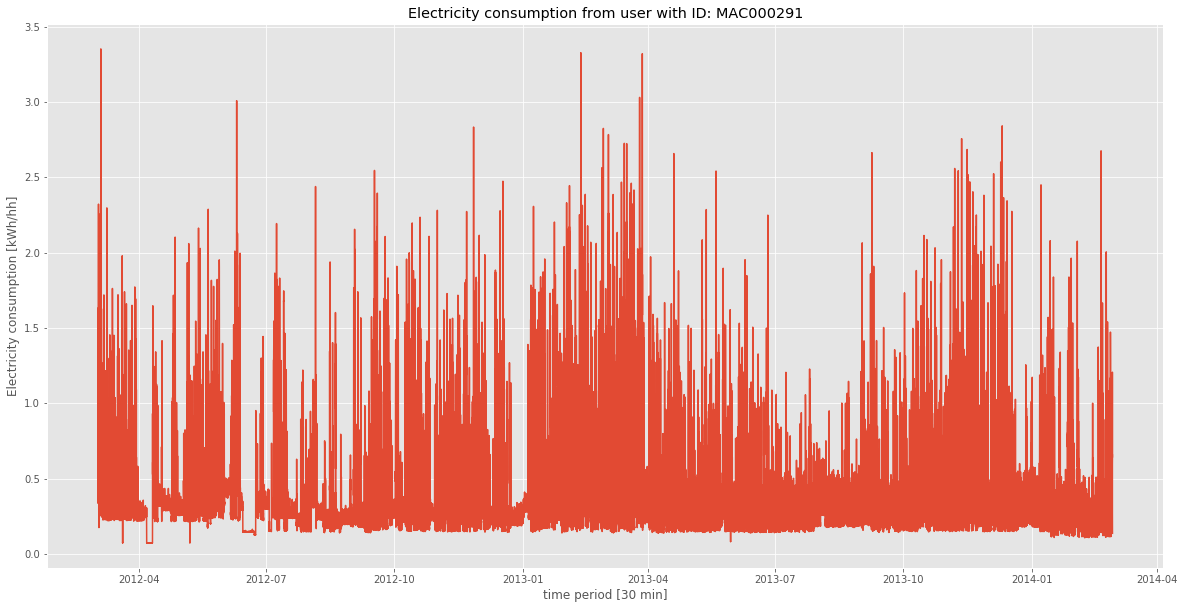

In [44]:
# Plotting the timeseries to see how the electricity consumption looks like. 
plt.figure(figsize=(20,10))
plt.plot(user_291_df.index, user_291_df['kWh/hh'])
plt.title('Electricity consumption from user with ID: MAC000291')
plt.xlabel('time period [30 min]')
plt.ylabel('Electricity consumption [kWh/hh]')

Text(0.5, 0, 'Time period [30 minutes]')

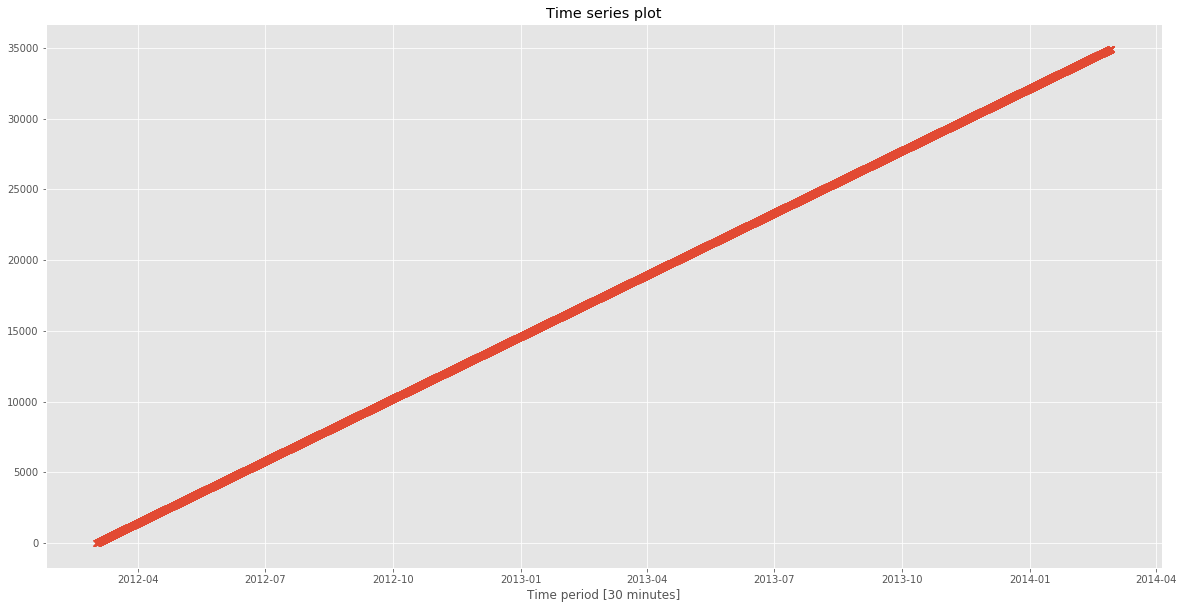

In [48]:
# Plotting to see that the evolution of the timestamp is linear and increasively, and that it is ordered. 
plt.figure(figsize=(20,10))
plt.plot(user_291_df.index, range(len(user_291_df)), 'x')
plt.title('Time series plot')
plt.xlabel('Time period [30 minutes]')

In [36]:
# Calculating the amount of data we have in 2012.
user_291_df['2012'].shape

(14620, 1)

In [37]:
# Calculating the amount of data we have in 2012.
user_291_df['2013'].shape

(17519, 1)

In [38]:
# Calculating the amount of data we have in 2012.
user_291_df['2014'].shape

(2784, 1)

As we can see from the cell above, our data is correctly structured. then, we can start with the performance of the time-series analysis. 

### 1.2. Time-Series Preprocessing

Before creating a model to forecast the electricity consumption based on a TS model, we need to answer some questions. 

1. Is the electricity consumption autocorrelated? 
2. Is there a seasonality?
3. Is it stationary? 

#### 1.2.1. Is the electricity consumption autocorrelated? Check for autocorrelation

Is the variable related with itself but with a lag period (previous time-period)? 

it uses previous observations in the TS to predict the next value in the model. When working with time series data, our response variable depends not only on the predictor variables but also on the response variable itself.

In [ ]:
### Com mirem això? 

#### 1.2.2. Is there a seasonality? 
We understand seasonality as periodic fluctuations. We can understand seasonality as for example, when electricity consumption is high during the day and low during the night. Seasonality can also be derived from an autocorrelation plot if it has a sinusoidal shape. 

#### 1.2.3. Is it stationary? Dickey-Fuller Test
Stationary is an important characteristic of Time-Series. 

We understand stationarity if its statistical properties do not change over time. That means:

- It has constant mean & variance 
- Covariance is independent of time. 

Ideally, we want a time-series to be stationary, since it makes it "easier" to model. However, if we have non-stationary data, we can remove these trends to make them stationary.

To check whether data is stationary or not, we perform a Dickey-Fuller Test. In this hipotheses these our hypotheses are: 

$H_0$

$H_A$

### 1.3. Time-Series Decomposition

In order to have a better understanding of the time-series, we can create a moving average to see whats happpening.


In [61]:
moving_avg_30min = user_291_df.rolling(30).mean() #we create a moving average with 30 minutes
moving_avg_60min = user_291_df.rolling(60).mean() #we create a moving average with 60 minutes
moving_avg_720min = user_291_df.rolling(720).mean() #we create a moving average with 720 minutes

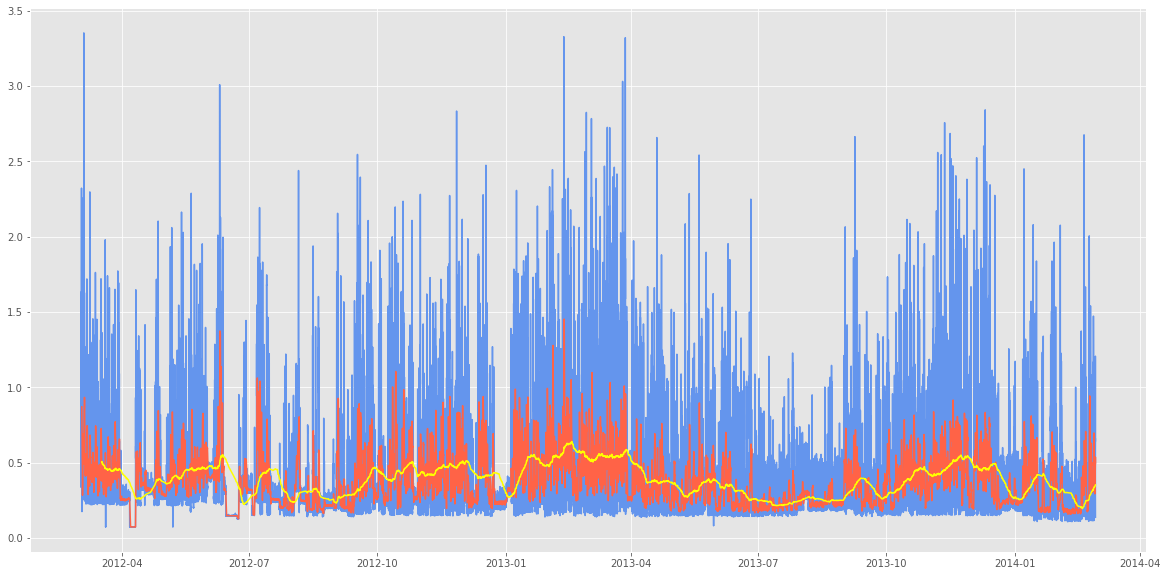

In [62]:
plt.figure(figsize=(20,10))
plt.plot(user_291_df, color='cornflowerblue')
plt.plot(moving_avg_30min, color='tomato')
#plt.plot(moving_avg_40, color='green')
plt.plot(moving_avg_720min, color='yellow')
#plt.plot(moving_avg_200, color='pink')

plt.show()

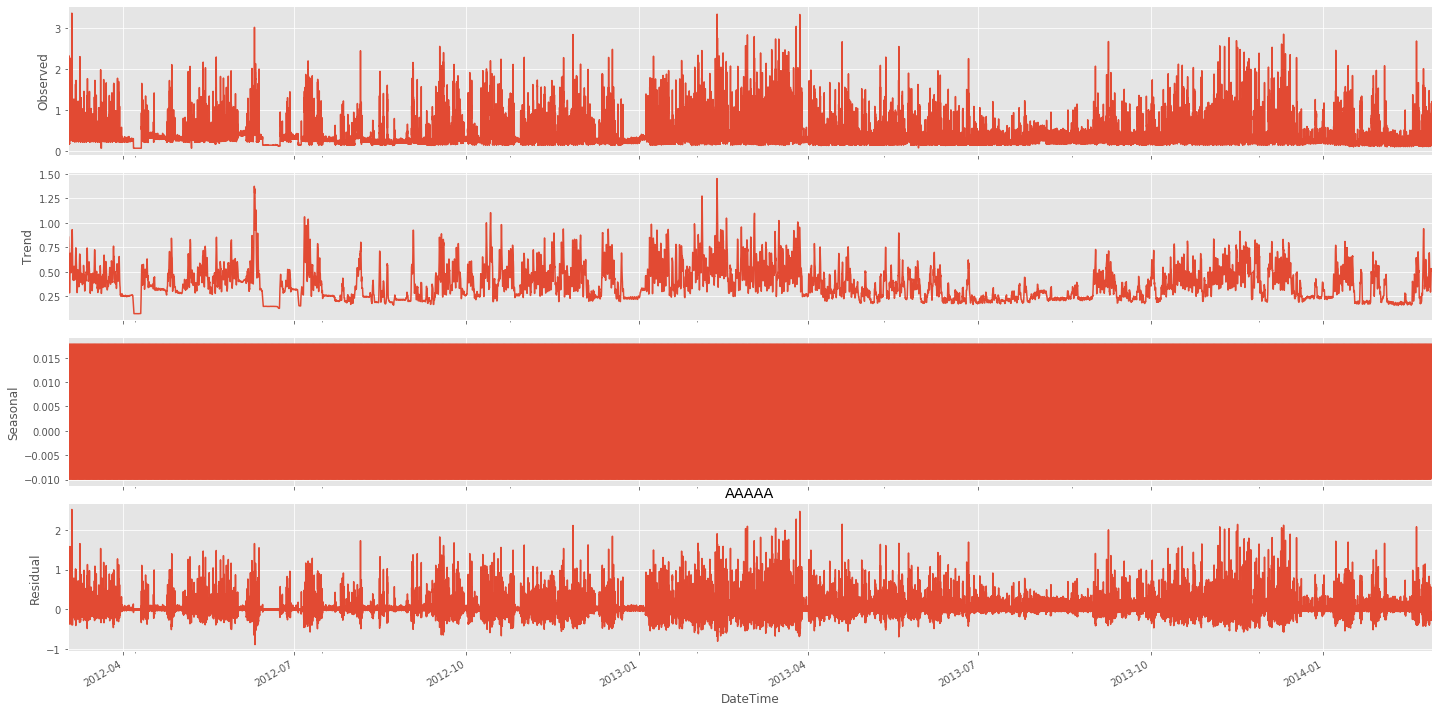

In [65]:
plt.rcParams["figure.figsize"] = [20, 10]
decomposed = sm.tsa.seasonal_decompose(user_291_df['kWh/hh'], freq=30)
decomposed_plot = decomposed.plot()

plt.title('AAAAA')

plt.show()



In [ ]:
plt.rcParams["figure.figsize"] = [20, 10]
decomposed = sm.tsa.seasonal_decompose(user_291_df['kWh/hh'], freq=30)
decomposed_plot = decomposed.plot()

plt.title('AAAAA')

plt.show()
